Text(0.5, 1.0, 'Correlated Random Variables')

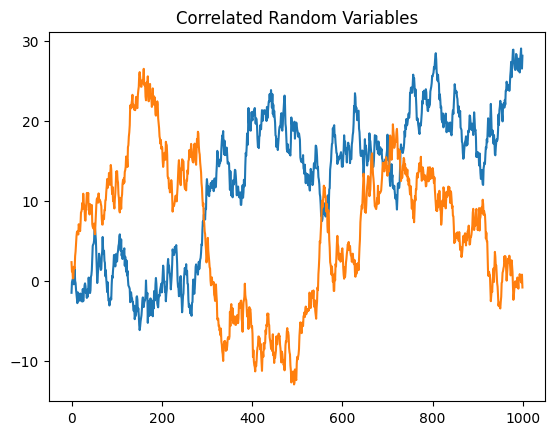

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal
import random


rho = -0.7
Ndraws = 1000
mu = np.array([0,0])
cov = np.array([[1, rho] , [rho , 1]])

W = np.random.multivariate_normal(mu, cov, size=Ndraws)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')

In [ ]:
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi,
                          steps, Npaths, return_vol=True):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]),
                                           cov = np.array([[1,rho],
                                                          [rho,1]]),
                                           size=paths) * np.sqrt(dt)

        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t

    if return_vol:
        return prices, sigs

    return prices

In [ ]:
kappa =4
theta = 0.1
v_0 =  0.05
xi = 0.9
r = 0.04
S = 60
paths =1000
steps = 365
T = 1

prices_pos1 , volatility1= generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.3, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=True)
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T ,
                                np.sqrt(theta)*np.sqrt(T), size=paths))
prices_pos1=prices_pos1 [-1,:]
volatility1 = volatility1 [-1,:]

#################################
#################################
#################################

S2 = 40
V2 = 0.05

prices_pos2 , volatility2= generate_heston_paths(S2, T, r, kappa, theta,
                                    V2, rho=0.3, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=True)
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T ,
                                np.sqrt(theta)*np.sqrt(T), size=paths))
prices_pos2 =prices_pos2 [-1,:]
volatility2 = volatility2 [-1,:]
#################################
#################################
#################################

S3 = 148
V3 = 0.1
prices_pos3 , volatility3 = generate_heston_paths(S3, T, r, kappa, theta,
                                    V3, rho=0.3, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=True)
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T ,
                                np.sqrt(theta)*np.sqrt(T), size=paths))
prices_pos3=prices_pos3 [-1,:]
volatility3 = volatility3 [-1,:]

###############################
###############################
###############################

S4 =30
V4 = 0.05

prices_pos4 , volatility4= generate_heston_paths(S4, T, r, kappa, theta,
                                    V4, rho=0.3, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=True)
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.6, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T ,
                                np.sqrt(theta)*np.sqrt(T), size=paths))
prices_pos4=prices_pos4 [-1,:]
volatility4 = volatility4 [-1,:]



In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
N = norm.cdf

def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)


def implied_vol(opt_value, S, K, T, r, type_='call'):

    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)

    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)

    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")

In [ ]:

np_maturity_all = np.zeros(0)
np_puts_all = np.zeros(0)
np_strike_prices_all = np.zeros(0)
np_price_all = np.zeros(0)
np_implied_volatility_all = np.zeros(0)
np_int_rate_all = np.zeros(0)
index_names = []
ind=0
for maturity in range(30,360,30):

          for i in range(0,360,2):
              strikes = []
              for j in range(60,240,5):
                  x = j *0.5
                  if (x%15 ==0 or abs(prices_pos1[i]-x)<4):
                    strikes.append(x)
              strikes = np.array(strikes)
              puts = []
              stock_price = []
              strike_price = []
              maturity_day = []
              int_rate = []
              if(maturity>i):
                    for K in strikes:
                        ind=ind+1
                        P = max(K-prices_pos1[i],0)
                        P = P*np.exp(-r*T)
                        noise = normal(1,0.35)
                        while noise<0:
                          noise = normal(1,0.35)
                        P = P * noise

                        interest = normal(0.02,0.004)

                        while interest < 0:

                             interest = normal(0.02,0.004)



                        int_rate.append(interest)


                        maturity_day.append(maturity-i)
                        strike_price.append(K)
                        stock_price.append(prices_pos1[i])
                        index = 't'+str(i)
                        index_names.append(index)
                        puts.append(P)


                    ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

                    puts_np = np.array(puts)
                    ivs_np =  np.array(ivs)
                    strike_np = np.array(strike_price)
                    maturity_np = np.array(maturity_day)
                    prices_np = np.array(stock_price)
                    int_np = np.array(int_rate)


                    np_strike_prices_all = np.concatenate((np_strike_prices_all,strike_np),axis=0)
                    np_puts_all = np.concatenate((np_puts_all,puts_np),axis=0)
                    np_price_all = np.concatenate((np_price_all, prices_np),axis = 0)
                    np_implied_volatility_all = np.concatenate((np_implied_volatility_all,ivs_np),axis = 0)
                    np_maturity_all =  np.concatenate((np_maturity_all,maturity_np),axis = 0)
                    np_int_rate_all = np.concatenate((np_int_rate_all,int_np),axis=0)


# creating a list of column names


# creating the dataframe
column_values = ['Put_Prices']
df1 = pd.DataFrame(data = np_puts_all,

                  columns = column_values)

norm = normal(0.045,0.008,len(np_int_rate_all))
df1['Stock_Prices'] = np_price_all
df1['Implied_Volatility'] = np_implied_volatility_all
df1['Implied_Volatility'].apply(lambda x: random.randint(1,50)*0.01 if x <= 0.01 else x )
df1['Strike_Prices'] = np_strike_prices_all
df1['Dividend_Yield'] = norm
df1['Maturity'] = np_maturity_all
df1['Moneyness'] = np_price_all/np_strike_prices_all
df1['Interest_Rates'] = np_int_rate_all
df1['Time_Step'] = index_names
df1['Company_Brand'] = 'KO'


print(len(np_int_rate_all))


8612


In [ ]:

np_maturity_all = np.zeros(0)
np_puts_all = np.zeros(0)
np_strike_prices_all = np.zeros(0)
np_price_all = np.zeros(0)
np_implied_volatility_all = np.zeros(0)
np_int_rate_all = np.zeros(0)
index_names = []
ind=0
for maturity in range(60,360,45):

          for i in range(0,360,3):
              strikes = []
              for j in range(40,160,2):
                  x = j *0.5
                  if (x%10 ==0 or abs(prices_pos2[i]-x)<3):
                    strikes.append(x)
              strikes = np.array(strikes)
              puts = []
              stock_price = []
              strike_price = []
              maturity_day = []
              int_rate = []
              if(maturity>i):
                    for K in strikes:
                        ind=ind+1
                        P = max(K-prices_pos2[i],0)
                        P = P*np.exp(-r*T)
                        noise = normal(1,0.35)
                        while noise<0:
                          noise = normal(1,0.35)
                        P = P * noise

                        interest = normal(0.035,0.002)

                        while interest < 0:

                             interest = normal(0.035,0.002)



                        int_rate.append(interest)


                        maturity_day.append(maturity-i)
                        strike_price.append(K)
                        stock_price.append(prices_pos2[i])
                        index = 't'+str(i)
                        index_names.append(index)
                        puts.append(P)


                    ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

                    puts_np = np.array(puts)
                    ivs_np =  np.array(ivs)
                    strike_np = np.array(strike_price)
                    maturity_np = np.array(maturity_day)
                    prices_np = np.array(stock_price)
                    int_np = np.array(int_rate)


                    np_strike_prices_all = np.concatenate((np_strike_prices_all,strike_np),axis=0)
                    np_puts_all = np.concatenate((np_puts_all,puts_np),axis=0)
                    np_price_all = np.concatenate((np_price_all, prices_np),axis = 0)
                    np_implied_volatility_all = np.concatenate((np_implied_volatility_all,ivs_np),axis = 0)
                    np_maturity_all =  np.concatenate((np_maturity_all,maturity_np),axis = 0)
                    np_int_rate_all = np.concatenate((np_int_rate_all,int_np),axis=0)


# creating a list of column names


# creating the dataframe
norm2 = normal(0.028,0.008,len(np_int_rate_all))
column_values = ['Put_Prices']
df2 = pd.DataFrame(data = np_puts_all,

                  columns = column_values)


df2['Stock_Prices'] = np_price_all
df2['Implied_Volatility'] = np_implied_volatility_all
df2['Implied_Volatility'].apply(lambda x: random.randint(1,50)*0.01 if x <= 0.01 else x )
df2['Strike_Prices'] = np_strike_prices_all
df2['Dividend_Yield'] = norm2
df2['Maturity'] = np_maturity_all
df2['Moneyness'] = np_price_all/np_strike_prices_all
df2['Interest_Rates'] = np_int_rate_all
df2['Time_Step'] = index_names
df2['Company_Brand'] = 'GM'

print(len(np_int_rate_all))

5044


In [ ]:

np_maturity_all = np.zeros(0)
np_puts_all = np.zeros(0)
np_strike_prices_all = np.zeros(0)
np_price_all = np.zeros(0)
np_implied_volatility_all = np.zeros(0)
np_int_rate_all = np.zeros(0)
index_names = []
ind=0
for maturity in range(30,360,30):

          for i in range(0,360,3):
              strikes = []
              for j in range(200,600,5):
                  x = j *0.5
                  if (x%50 ==0 or abs(prices_pos3[i]-x)<8):
                    strikes.append(x)
              strikes = np.array(strikes)
              puts = []
              stock_price = []
              strike_price = []
              maturity_day = []
              int_rate = []
              if(maturity>i):
                    for K in strikes:
                        ind=ind+1
                        P = max(K-prices_pos3[i],0)
                        P = P*np.exp(-r*T)
                        noise = normal(1,0.35)
                        while noise<0:
                          noise = normal(1,0.35)
                        P = P * noise

                        interest = normal(0.25,0.04)

                        while interest < 0:

                             interest = normal(0.25,0.04)



                        int_rate.append(interest)


                        maturity_day.append(maturity-i)
                        strike_price.append(K)
                        stock_price.append(prices_pos3[i])
                        index = 't'+str(i)
                        index_names.append(index)
                        puts.append(P)


                    ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

                    puts_np = np.array(puts)
                    ivs_np =  np.array(ivs)
                    strike_np = np.array(strike_price)
                    maturity_np = np.array(maturity_day)
                    prices_np = np.array(stock_price)
                    int_np = np.array(int_rate)


                    np_strike_prices_all = np.concatenate((np_strike_prices_all,strike_np),axis=0)
                    np_puts_all = np.concatenate((np_puts_all,puts_np),axis=0)
                    np_price_all = np.concatenate((np_price_all, prices_np),axis = 0)
                    np_implied_volatility_all = np.concatenate((np_implied_volatility_all,ivs_np),axis = 0)
                    np_maturity_all =  np.concatenate((np_maturity_all,maturity_np),axis = 0)
                    np_int_rate_all = np.concatenate((np_int_rate_all,int_np),axis=0)

# creating a list of column names


# creating the dataframe
column_values = ['Put_Prices']
df3 = pd.DataFrame(data = np_puts_all,

                  columns = column_values)

norm3 = normal(0.040,0.008,len(np_int_rate_all))
df3['Stock_Prices'] = np_price_all
df3['Implied_Volatility'] = np_implied_volatility_all
df3['Implied_Volatility'].apply(lambda x: random.randint(1,50)*0.01 if x <= 0.01 else x )
df3['Strike_Prices'] = np_strike_prices_all
df3['Dividend_Yield'] = norm3
df3['Maturity'] = np_maturity_all
df3['Moneyness'] = np_price_all/np_strike_prices_all
df3['Interest_Rates'] = np_int_rate_all
df3['Time_Step'] = index_names
df3['Company_Brand'] = 'PG'
print(len(np_int_rate_all))


6572


In [ ]:

np_maturity_all = np.zeros(0)
np_puts_all = np.zeros(0)
np_strike_prices_all = np.zeros(0)
np_price_all = np.zeros(0)
np_implied_volatility_all = np.zeros(0)
np_int_rate_all = np.zeros(0)
index_names = []
ind=0
for maturity in range(150,459,60):

          for i in range(0,360,30):
              strikes = []
              for j in range(30,120,2):
                  x = j *0.5
                  if (x%10 ==0 or abs(prices_pos4[i]-x)<3):
                    strikes.append(x)
              strikes = np.array(strikes)
              puts = []
              stock_price = []
              strike_price = []
              maturity_day = []
              int_rate = []
              if(maturity>i):
                    for K in strikes:
                        ind=ind+1
                        P = max(K-prices_pos4[i],0)
                        P = P*np.exp(-r*T)
                        noise = normal(1,0.35)
                        while noise<0:
                          noise = normal(1,0.35)
                        P = P * noise

                        interest = normal(0.25,0.04)

                        while interest < 0:

                             interest = normal(0.25,0.04)



                        int_rate.append(interest)


                        maturity_day.append(maturity-i)
                        strike_price.append(K)
                        stock_price.append(prices_pos4[i])
                        index = 't'+str(i)
                        index_names.append(index)
                        puts.append(P)


                    ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]

                    puts_np = np.array(puts)
                    ivs_np =  np.array(ivs)
                    strike_np = np.array(strike_price)
                    maturity_np = np.array(maturity_day)
                    prices_np = np.array(stock_price)
                    int_np = np.array(int_rate)


                    np_strike_prices_all = np.concatenate((np_strike_prices_all,strike_np),axis=0)
                    np_puts_all = np.concatenate((np_puts_all,puts_np),axis=0)
                    np_price_all = np.concatenate((np_price_all, prices_np),axis = 0)
                    np_implied_volatility_all = np.concatenate((np_implied_volatility_all,ivs_np),axis = 0)
                    np_maturity_all =  np.concatenate((np_maturity_all,maturity_np),axis = 0)
                    np_int_rate_all = np.concatenate((np_int_rate_all,int_np),axis=0)


# creating a list of column names


# creating the dataframe
column_values = ['Put_Prices']
df4 = pd.DataFrame(data = np_puts_all,

                  columns = column_values)

norm4 = normal(0.030,0.008,len(np_int_rate_all))

df4['Stock_Prices'] = np_price_all
df4['Implied_Volatility'] = np_implied_volatility_all
df4['Implied_Volatility'].apply(lambda x: random.randint(1,50)*0.01 if x <= 0.01 else x )
df4['Strike_Prices'] = np_strike_prices_all
df4['Dividend_Yield'] = norm4
df4['Dividend_Yield'].apply(lambda x: random.randint(1,50)*0.01 if x <= 0.01 else x )

df4['Maturity'] = np_maturity_all
df4['Moneyness'] = np_price_all/np_strike_prices_all
df4['Interest_Rates'] = np_int_rate_all
df4['Time_Step'] = index_names
df4['Company_Brand'] = 'BAC'
print(len(np_int_rate_all))

516


In [ ]:
frames = [df1, df2,df3,df4]
result = pd.concat(frames)
result.to_csv('finaltemp.csv',encoding='utf-8')